# TWITTER ANALYSIS - MENTORSHIP PROJECT


#### STEP 1. CONFIGURATION: ESTABLISHING CONNECTION TO THE API
*Using Tweepy*

In [2]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time

In [3]:
#read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key             = config['twitter']['api_key']
api_key_secret      = config['twitter']['api_key_secret']

access_token        = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

bearer_token        = config['twitter']['bearer_token']

In [4]:
#Authenticate our account with the Twitter API
auth    = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api     = tweepy.API(auth)

# You can authenticate as your app with just your bearer token
client  = tweepy.Client(bearer_token=bearer_token)

# If the authentication was successful, this should print the
# screen name / username of the account
print(api.verify_credentials().screen_name)

KLuthra_


### STEP 2. DATA EXTRACTION
####  2.1. Defining a tweet fetching function using Tweepy

**__Pagination:__** Pagination is a feature in Twitter API v2 endpoints that return more results than can be returned in a single response. When that happens, the data is returned in a series of 'pages'. Pagination refers to methods for programatically requesting all of the pages, in order to retrieve the entire result data set. Not all API endpoints support or require pagination, but it is often used when result sets are large.

**Paginator** can be used to paginate for any Client methods that support pagination

In [5]:
def get_tweets(query, max_results, next_token = None):

  expansions    = ['author_id','in_reply_to_user_id','geo.place_id','entities.mentions.username','referenced_tweets.id','referenced_tweets.id.author_id']
  tweet_fields  = ['id','text','author_id','attachments','context_annotations','created_at','entities','lang','geo','public_metrics']
  user_fields   = ['id','name','username','created_at','description','entities','location','public_metrics','verified']
  place_fields  = ['full_name','id','country','country_code','geo','name','place_type']
  try:
    # call twitter api to fetch tweets
    fetched_tweets = client.search_recent_tweets(query,
      expansions        =expansions,
      tweet_fields      =tweet_fields,
      place_fields      =place_fields,
      user_fields       =user_fields,
      next_token        =next_token,
      max_results       =max_results
    )
    
    return fetched_tweets
    

  except Exception as e:
    print("Error getting tweets", e)

####  2.2. Extracting Domains and Entities from the Twitter API
*Annotations have been added to the Tweet object from all v2 endpoints that return a Tweet object. Tweet annotations offer a way to understand contextual information about the Tweet itself. Though 100% of Tweets are reviewed, due to the contents of Tweet text, only a portion are annotated.*

##### Tweet annotation types
**Entities** Entity annotations are programmatically defined entities that are nested within the entities field and are reflected as annotations in the payload. Each annotation has a confidence score and an indication of where in the Tweet text the entities were identified (start and end fields).

The entity annotations can have the following types:

1. Person - Barack Obama, Daniel, or George W. Bush
2. Place - Detroit, Cali, or "San Francisco, California"
3. Product - Mountain Dew, Mozilla Firefox
4. Organization - Chicago White Sox, IBM
5. Other - Diabetes, Super Bowl 50

**Context annotations** are delivered as a context_annotations field in the payload. These annotations are inferred based on semantic analysis (keywords, hashtags, handles, etc) of the Tweet text and result in domain and/or entity labels. Context annotations can yield one or many domains. At present, we’re using a list of 80+ domains reflected in the table below.  
1. ID - 45: Brand Vertical
2. ID - 46: Brand Category
3. ID - 47: Brand
4. ID - 48: Product

In [6]:
# read the CSV file and store it in a DataFrame
df = pd.read_csv('twitter-context-annotations/files/evergreen-context-entities-20220601.csv')

def domain_filter(df):
    context_list = []
    mask = df['domains'].str.contains('^45$')
    filtered_df = df[mask]
    for index, row in filtered_df.iterrows():
        domain_id = row['domains']
        entity_id = row['entity_id']
        entity_name = row['entity_name']   
        # construct the query string
        context = f'context:{domain_id}.{entity_id}'
        context_list.append(context)
        context_query = ' OR '.join(context_list)
    return context_query

##### 2.2.1 DOMAIN-ENTITY QUERY CONSTRUCTION 
The *search_recent_tweets* function within the Twitter API has a query limit of 512 characters. To work around this, I have created a list of strings, less than 512 characters long, which contain the domain_id.entity_id search query broken up into chunks of 512 characters or less each which I will iterate through when making API requests to retrieve tweets

In [13]:
#DOMAIN 45 : < 1 CHUNK
#DOMAIN 46 : < 5 CHUNK
#DOMAIN 47 : < 240 CHUNK
#DOMAIN 45 : < 61 CHUNK

context     = domain_filter(df)
chunk_size  = 400
code        = context
chunks      = []
start       = 0
counter     = 0
while start < len(code) and counter < 1:
    end = start + chunk_size
    if end >= len(code):
        end = len(code)
    end = code.rfind(" OR ", start, end)
    if end == -1:
        end = start + chunk_size
    chunk = code[start:end]
    if chunk.startswith(" OR "):
        chunk = chunk[4:]
    chunks.append(chunk)
    start = end
    counter += 1

# print (chunks)

##### 2.2.2 Defining Pre-Extraction Filtering 

In [8]:
def filter_rule(chunk):
    hashtag_list    = '(#ad OR #sponsored OR #promoted OR #promotion)'
    lang            = '(lang:en)'
    rt              = '(-is:retweet) (-"RT")' 
    domain          =  chunk
    mention         = 'has:mentions'
    query           = hashtag_list + ' ' + lang + ' ' + rt + ' ' +  mention + ' ' + '(' + domain + ')'
    return query

In [9]:
import csv
total_tweets = 0

csvFile     = open("test.csv", "a", newline="", encoding='utf-8')
csvWriter   = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
# csvWriter.writerow(['author_id', 'created_at', 'tweet_id','text'])
csvFile.close()


In [10]:
def append_to_csv(data, fileName):

    #A counter variable
    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    # for tweet in json_response['data']:
    #     # We will create a variable for each since some of the keys might not exist for some tweets
    #     # So we will account for that
   
    #     # 1. Author ID
    #     author_id = tweet['author_id']
    #     # 2. Time created
    #     created_at = dateutil.parser.parse(tweet['created_at']) 
    #     # 3. Tweet ID
    #     tweet_id = tweet['id']
    #     # 4. Tweet text
    #     text = tweet['text']
    #     # Assemble all data in a list
    #     res = [author_id, created_at, tweet_id, text]
        
    # Assemble all data in a list
    res = [data['author_id'], data['created_at'], data['tweet_id'], data['text']]
    # Append the result to the CSV file
    csvWriter.writerow(res)
    # counter += 1
    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    # print("# of Tweets added from this response: ", counter) 

In [11]:
def deduplicate(file_path):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates(subset=['tweet_id'])
    df = df.sort_values(by='created_at',ascending=False)
    df.to_csv(file_path, index=False)

In [14]:
for chunk in chunks:
        print(f'Chunk: {chunk}')
        # read CSV file
        results = pd.read_csv('test.csv')
        # count no. of lines
        print("Number of lines pre-extraction:-", 
        len(results))
        query       = filter_rule(chunk=chunk)
        paginator   = tweepy.Paginator(client.search_recent_tweets, query=query, 
                                        expansions    = ['author_id','in_reply_to_user_id','geo.place_id','entities.mentions.username','referenced_tweets.id','referenced_tweets.id.author_id'],
                                        tweet_fields  = ['id','text','author_id','attachments','context_annotations','created_at','entities','lang','geo','public_metrics'],
                                        user_fields   = ['id','name','username','created_at','description','entities','location','public_metrics','verified'],
                                        place_fields  = ['full_name','id','country','country_code','geo','name','place_type'], max_results=100).flatten()
        for tweet in paginator:
        # Assemble all data in a list
                data = {"author_id": tweet.author_id,
                        "created_at":tweet.created_at,
                        "tweet_id": tweet.id,
                        "text": tweet.text}
                append_to_csv(data, fileName="test.csv")

        time.sleep(16)
        results = pd.read_csv('test.csv')
        # count no. of lines
        print("Number of lines post-extraction:-", 
        len(results))
 
deduplicate("test.csv")

Chunk: context:45.781972125171060736 OR context:45.781974597226799105 OR context:45.781974596740190208 OR context:45.781974596161376261 OR context:45.781974597474263040 OR context:45.781974597310615553 OR context:45.781974596157251587
Number of lines pre-extraction:- 4221
Number of lines post-extraction:- 5220


In [15]:
results = pd.read_csv('test.csv')
        # count no. of lines
print("Number of lines post-extraction:-",  len(results))

Number of lines post-extraction:- 3265


In [ ]:
df = pd.read_csv("data.csv")
df.to_json(r'data.json',orient='records')

In [ ]:
#input
import csv
count           = 0
max_results     = 100 #per Page
# flag            = True
# next_token      = None

for chunk in chunks:
    flag        = True
    next_token  = None
    print(f'Chunk: {chunk}')
    query       = filter_rule(chunk=chunk)
    while flag:
       
        print("--------------------")
        print("Token: ", next_token)
        tweets  = get_tweets(query=query,next_token=next_token,max_results=max_results)
        tweets_dict = tweets.json() 
        result_count = tweets_dict['meta']['result_count'] 

        if 'next_token' in tweets_dict['meta']:
            next_token = tweets_dict['meta']['next_token']
            print("Next Token: ", next_token)

            if result_count is not None and result_count > 0 and next_token is not None:
                append_to_csv(tweets_dict, "test.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("--------------------------")
                time.sleep(5)

            # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                append_to_csv(tweets_dict, "test.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
                    
                #Since this is the final request, turn flag to false to move to the next time period.
                flag = False
                next_token = None
        time.sleep(5)

# df = pd.read_csv("data.csv")       
print("Total number of results: ", total_tweets)
deduplicate("test.csv")

In [178]:
from operator import itemgetter

tweets          = None
requests_lists  = []
next_token      = None

tweets  = get_tweets(query=filter_rule(),next_token=next_token,max_results=100)
tweets_dict = tweets.json() 
tweets_data = tweets_dict["data"]
tweets_NT   = tweets_dict["meta"]

# df = pd.DataFrame(tweets_dict['data'])
# #WHILE LOOP UNTIL NEXT_TOKEN IS NULL OR BLANK
# while next_token is not None:
#     tweets  = get_tweets(query=filter_rule(),next_token=next_token,max_results=100)

#     # Save data as dictionary
#     tweets_dict = tweets.json() 
    
#     tweets_data     = tweets_dict["data"]
#     # tweets_includes = tweets_dict["includes"]
#     tweets_NT       = tweets_dict["meta"]["next_token"]
    
# users = tweets_includes["users"]
# users = {user["id"]: user for user in users}

# for tweet in tweets_data:
#     author_id = int(tweet["author_id"])
#     print(f'USER ID:                    {users[tweet["author_id"]]["id"]}')
#     print(f'USER NAME:                  {users[tweet["author_id"]]["name"]}')
#     print(f'HANDLE:                     {users[tweet["author_id"]]["username"]}')
#     print(f'VERIFIED:                   {users[tweet["author_id"]]["verified"]}')
#     print(f'BIO:                        {users[tweet["author_id"]]["description"]}')
#     print(f'METRICS:                    {users[tweet["author_id"]]["public_metrics"]}')
#     print(f"TWEET ID:                   {tweet['id']}") 
#     print(f"TEXT:                       {tweet['text']}")
#     print(f"CREATED AT:                 {tweet['created_at']}")
#     print(f"TWEET METRICS:              {tweet['public_metrics']}")
#     context_annotations = tweet.get("context_annotations",[])
#     print(f"CONTEXT - DOMAIN:           {list(map(itemgetter('domain'), context_annotations))}")
#     print(f"CONTEXT - ENTITY:           {list(map(itemgetter('entity'), context_annotations))}")
#     entities = tweet.get("entities",[])
#     print(f"ENTITIES:                   {entities}\n")


    # Create a dataframe
    # df = pd.DataFrame(tweets_dict['data'])
    # # save to csv
    # df.to_csv('tweets.csv', index=False)

Final note: I would not try to work with pandas dataframes to write your file. I would create an empty list, append the results from each new query to that list, and then write the final list of dictionary objects to a json file (see this question for details). I've learned the hard way that raw tweets and pandas dataframes don't really play nice. Much better to get used to how json objects and dictionaries work.


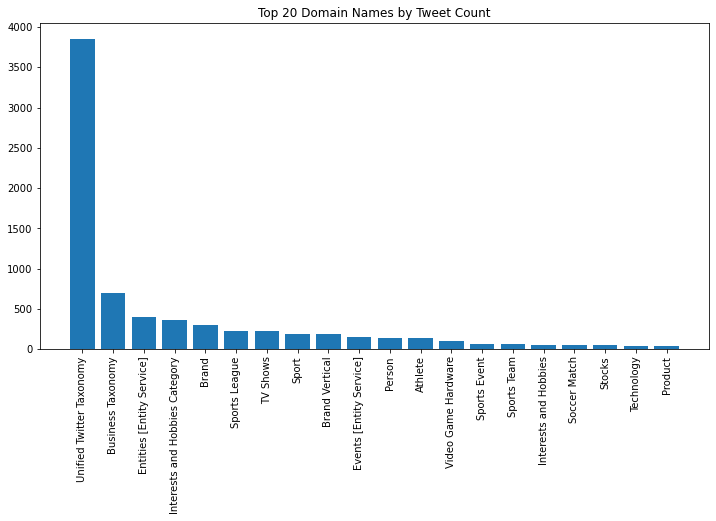

In [124]:
import matplotlib.pyplot as plt

# Extract the domain names from the Domain_Name field
domain_names = [name for row in df['Domain_Name'] for name in row]

# Use the Counter function from the collections module to count the number of tweets for each domain
from collections import Counter
domain_counts = Counter(domain_names)

# Sort the domain names by count in descending order
sorted_domain_counts = sorted(domain_counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 20 domain names and tweet counts
top_20_domains = sorted_domain_counts[:20]
domains = [domain for domain, count in top_20_domains]
tweet_counts = [count for domain, count in top_20_domains]

# Create a figure with a larger size
fig = plt.figure(figsize=(12, 6))

# Create a bar plot of the tweet count for each domain
plt.bar(domains, tweet_counts)

# Add a title to the plot
plt.title('Top 20 Domain Names by Tweet Count')

# Rotate the tick labels to make them easier to read
plt.xticks(rotation=90)

plt.show()

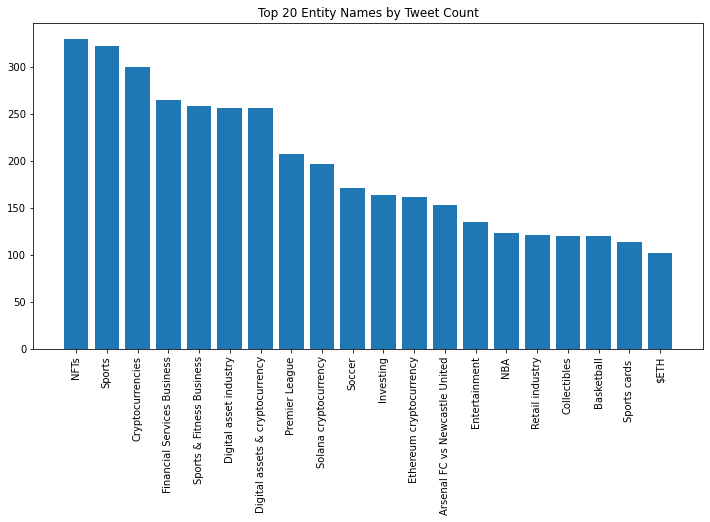

In [125]:
import matplotlib.pyplot as plt

# Extract the entity names from the Entity_Name field
entity_names = [name for row in db['Entity_Name'] for name in row]

# Use the Counter function from the collections module to count the number of tweets for each entity
from collections import Counter
entity_counts = Counter(entity_names)

# Sort the entity names by count in descending order
sorted_entity_counts = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 20 entity names and tweet counts
top_20_entities = sorted_entity_counts[:20]
entities = [entity for entity, count in top_20_entities]
tweet_counts = [count for entity, count in top_20_entities]

# Create a figure with a larger size
fig = plt.figure(figsize=(12, 6))

# Create a bar plot of the tweet count for each entity
plt.bar(entities, tweet_counts)

# Add a title to the plot
plt.title('Top 20 Entity Names by Tweet Count')

# Rotate the tick labels to make them easier to read
plt.xticks(rotation=90)

plt.show()

#create a filter function which filters out anything that can classify as spam.
#DATA CLEANING
    - REMOVE 50 